# Previsão de dados de preços de ações da Bovespa

## Introdução

Para uma determinada ação, temos um conjunto de valores
que determinam as variações desta ao longo do tempo que
são:

3. Preço de alta: O preço mais alto que uma ação foi
   negociada em um determinado dia.
4. Preço de baixa: O preço mais baixo que uma ação foi
   negociada em um determinado dia.
1. Preço de abertura: O preço da ação ao iniciar o pregão
   num determinado dia.
2. Preço de fechamento: O último preço em que a ação foi
   negociada antes de fechar.
5. Preço de fechamento ajustado: O preço de fechamento da
   ação depois de aplicar todos os desdobramentos e
   distribuições de dividendos. Esse é o preço real de
   fechamento da ação.
6. Volume: O volume (quantidade) de ações negociadas no dia.

O problema que temos é justamente prever esses valores para
uma determinada ação um dado número de dias após o último dia
documentado nos dados que temos.

Nesse notebook, investigamos e buscamos uma solução para
esse problema usando apenas os dados dos preços anteriores
da própria ação em si, considerando possibilidades dentro
das limitações que surgem como consequência de tal desafio.

Uma consideração importante é que há vários fatores externos
que podem causar variações nos preços de dadas ações.
Portanto, um modelo mais eficiente consideraria o contexto
específico de mercado de cada ação, e seria atualizados
através de notícias relacionadas a esse contexto, podendo
englobar um modelo de processamento de linguagem natural em
conjunto com o modelo de previsão dos preços.

## Extração, análise e processamento dos dados

O dataset que usamos foi retirado desta página no kaggle:
[Brazilian Stock Market (daily updated)](https://www.kaggle.com/datasets/andrewmvd/brazilian-stock-market).

Primeiramente, iremos carregar nosso dataset:

In [53]:
import pandas as pd

data = pd.read_csv('data/bovespa_stocks.csv')

display(len(data))
display(data.head(6))

894776

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
0,2022-10-03,SMAB11,8.360000,8.360000,8.370000,7.970000,8.000000,579.0
1,2010-01-04,MMXM3,1599.174927,1599.174927,1599.174927,1555.137817,1556.395996,20984.0
2,2010-01-05,MMXM3,1609.240479,1609.240479,1616.789795,1567.719849,1600.433105,22586.0
3,2010-01-06,MMXM3,1680.958008,1680.958008,1685.990845,1599.174927,1616.789795,37998.0
4,2010-01-07,MMXM3,1698.572876,1698.572876,1704.863892,1641.953735,1660.826782,33651.0
5,2010-01-08,MMXM3,1712.413086,1712.413086,1748.901001,1709.896729,1711.154907,29992.0


In [54]:
display(data['Symbol'].unique())
display(data['Symbol'].nunique())

numberItems = pd.DataFrame(data.groupby(
    ['Symbol']).count().iloc[:, 0].sort_values())
display(numberItems)


array(['SMAB11', 'MMXM3', 'BMIN3', 'BRPR3', 'WEST3', 'JBSS3', 'ITUB3',
       'BMGB4', 'DEXP4', 'GRAO3', 'LAND3', 'CMIG3', 'B39', 'HOOT4',
       'STOC31', 'INEP3', 'BKYY39', 'DMMO3', 'CLSC4', 'SAPR11', 'BRSR6',
       'O3', 'D2KN34', 'PMAM3', 'PETR3', 'PETR4', 'CATP34', 'CTKA4',
       'CRPG5', 'CPLE5', 'BMLC11', 'SPXB11', 'ENMT4', 'BOEF39', 'IFCM3',
       'COLG34', 'BIYE39', 'RAIZ4', 'BRAP3', 'UPSS34', 'SBSP3', 'SANB3',
       'AFHI11', 'CEAB3', 'PGCO34', 'CASN4', 'GETT4', 'BBDC4', 'BIYT39',
       'TTEN3', 'CBAV3', 'MYPK3', 'GOGL35', 'RECR11', 'BPAN4', 'RNEW4',
       'JHSF3', 'JGPX11', 'BIVE39', 'CEGR3', 'CRPG3', 'MERC4', 'SANB4',
       'AMAR3', 'WHRL4', 'VSEC11', 'PCAR3', 'EQIR11', 'GEPA3', 'C3',
       'CAML3', 'BFXH39', 'ARML3', 'CPFE3', 'DESK3', 'RNEW3', 'RSID3',
       'BCWV39', 'PURB11', 'AMBP3', 'COGN3', 'BALM3', 'ABTT34', 'PEPB34',
       'AERI3', 'CSNA3', 'S2QS34', 'DOTZ3', 'ITUB4', 'BBDC3', 'AGXY3',
       'SMFT3', 'ALUP11', 'BIVW39', 'C2OI34', 'BEEF3', 'WFCO34', 'MORC1

454

,Date
Symbol,
GRAO3,1
KNCA11,1
BBGO11,1
HGAG11,1
BERU39,1
...,...
G3,9555
I4,9555
I3,9555


Como podemos ver, há uma quantidade relativamente grande
de símbolos, inclusive alguns que não são ações oficiais,
como H3, B39, que representam códigos de negociações no
lugar de ações específicas. Iremos retirar esses símbolos do nosso dataset.

Também retiraremos as ações com poucos dados (<500 linhas de dados):

In [55]:
data = data[data['Symbol'].str.fullmatch(r'\w{4}\d{1,2}')]

biggestIndices = numberItems[numberItems.iloc[:, 0] > 500].index
data = data[data['Symbol'].isin(biggestIndices)]

display(len(data))
display(data.head(6))
display(data['Symbol'].unique())
display(data['Symbol'].nunique())

773396

,Date,Symbol,Adj Close,Close,High,Low,Open,Volume
1,2010-01-04,MMXM3,1599.174927,1599.174927,1599.174927,1555.137817,1556.395996,20984.0
2,2010-01-05,MMXM3,1609.240479,1609.240479,1616.789795,1567.719849,1600.433105,22586.0
3,2010-01-06,MMXM3,1680.958008,1680.958008,1685.990845,1599.174927,1616.789795,37998.0
4,2010-01-07,MMXM3,1698.572876,1698.572876,1704.863892,1641.953735,1660.826782,33651.0
5,2010-01-08,MMXM3,1712.413086,1712.413086,1748.901001,1709.896729,1711.154907,29992.0
6,2010-01-11,MMXM3,1774.065063,1774.065063,1774.065063,1724.995117,1737.577148,34910.0


array(['MMXM3', 'BMIN3', 'BRPR3', 'JBSS3', 'ITUB3', 'BMGB4', 'DEXP4',
       'CMIG3', 'HOOT4', 'INEP3', 'DMMO3', 'CLSC4', 'SAPR11', 'BRSR6',
       'PMAM3', 'PETR3', 'PETR4', 'CATP34', 'CTKA4', 'CRPG5', 'CPLE5',
       'BMLC11', 'ENMT4', 'COLG34', 'BRAP3', 'UPSS34', 'SBSP3', 'SANB3',
       'CEAB3', 'PGCO34', 'CASN4', 'BBDC4', 'MYPK3', 'GOGL35', 'BPAN4',
       'RNEW4', 'JHSF3', 'CEGR3', 'CRPG3', 'MERC4', 'SANB4', 'AMAR3',
       'WHRL4', 'PCAR3', 'GEPA3', 'CAML3', 'CPFE3', 'RNEW3', 'RSID3',
       'AMBP3', 'COGN3', 'BALM3', 'ABTT34', 'PEPB34', 'AERI3', 'CSNA3',
       'ITUB4', 'BBDC3', 'ALUP11', 'BEEF3', 'WFCO34', 'RANI3', 'MOVI3',
       'VIVT3', 'CHVX34', 'CEBR3', 'CEED3', 'BRKM3', 'EXXO34', 'UNIP3',
       'EUCA3', 'RPMG3', 'CLSC3', 'OIBR4', 'XRXB34', 'WALM34', 'CVCB3',
       'NFLX34', 'CTKA3', 'CEPE6', 'BSLI3', 'DIRR3', 'HALI34', 'SLBG34',
       'CRFB3', 'AAPL34', 'MSFT34', 'ANIM3', 'NIKE34', 'SLED4', 'GRND3',
       'MELK3', 'ALPA3', 'APER3', 'LMTB34', 'FDXB34', 'IGTI3', 'HONB3

289

Agora precisamos fazer um tratamento dos dados.
Primeiramente, iremos mapear as datas para valores
inteiros. Por serem atributos importantes, também
extrairemos da data, colunas para ano, mês, semana
do ano, dia do ano, dia do mês, dia
da semana e trimestre:

In [56]:
# Pegando a menor data no dataset e usando ela como data inicial
dates = pd.to_datetime(data['Date'], utc=True)
startDate = dates.min()

dateData = data.copy()
dateData['Day'] = (dates - startDate).dt.days
dateData['Year'] = dates.dt.year - startDate.year
dateData['Month'] = dates.dt.month # [1-12]
dateData['YearWeek'] = dates.dt.isocalendar().week.astype('int') # [1-53]
dateData['YearDay'] = dates.dt.day_of_year  # [1-366]
dateData['MonthDay'] = dates.dt.day  # [1-31]
dateData['WeekDay'] = dates.dt.day_of_week  # [0-6]
dateData['Season'] = dates.dt.quarter  # [1-4]
dateData.drop('Date', axis=1, inplace=True)

display(dateData.head(6))


,Symbol,Adj Close,Close,High,Low,Open,Volume,Day,Year,Month,YearWeek,YearDay,MonthDay,WeekDay,Season
1,MMXM3,1599.174927,1599.174927,1599.174927,1555.137817,1556.395996,20984.0,0,0,1,1,4,4,0,1
2,MMXM3,1609.240479,1609.240479,1616.789795,1567.719849,1600.433105,22586.0,1,0,1,1,5,5,1,1
3,MMXM3,1680.958008,1680.958008,1685.990845,1599.174927,1616.789795,37998.0,2,0,1,1,6,6,2,1
4,MMXM3,1698.572876,1698.572876,1704.863892,1641.953735,1660.826782,33651.0,3,0,1,1,7,7,3,1
5,MMXM3,1712.413086,1712.413086,1748.901001,1709.896729,1711.154907,29992.0,4,0,1,1,8,8,4,1
6,MMXM3,1774.065063,1774.065063,1774.065063,1724.995117,1737.577148,34910.0,7,0,1,2,11,11,0,1


Agora, precisamos manter as propriedades cíclicas desses valores,
considerando que o próximo valor do último valor é o valor inicial.
Por exemplo o dia do mês depois do 31 é o 1, não o 32.
Para isso, transformaremos primeiro os valores para que 0
corresponda ao valor inicial e 1 corresponda ao valor final médio
(não será o valor final, pois há casos que esse final varia, como,
por exemplo, com dias do mês que pode variar de 28 a 31). Para os
valores que começam em 0, o valor final e o inicial serão mapeados
para zero. Portanto, precisamos somar 1 a esses valores para evitar
o problema.

Para que os valores nas bordas sejam os mesmos, podemos usar um
seno ou cosseno. Usaremos os dois, considerando as propriedades
de ortogonalidade que tem entre si para completude do sistema.
O cálculo, portanto, será:

$$ x'_1 = sin \bigg(\frac{2 \pi x}{m} \bigg) $$
$$ x'_2 = cos \bigg(\frac{2 \pi x}{m} \bigg) $$

, onde $m$ é o tamanho médio do intervalo, $x$ é o valor que temos
e $x'$ o valor que queremos.

A implementação, portanto, fica:

In [57]:
import numpy as np


def create_cyclic(data, prop, cycle_size, add_one=False):
    d = (data[prop] + 1) if add_one else data[prop]
    cycle_size = cycle_size + (1 if add_one else 0)
    data[prop + '_Sin'] = np.sin(2 * np.pi * d / cycle_size)
    data[prop + '_Cos'] = np.cos(2 * np.pi * d / cycle_size)
    data.drop(prop, axis=1, inplace=True)


cyclicData = dateData.copy()
create_cyclic(cyclicData, 'Month', 12)
create_cyclic(cyclicData, 'YearWeek', 52)
create_cyclic(cyclicData, 'YearDay', 365)
create_cyclic(cyclicData, 'MonthDay', 31)
create_cyclic(cyclicData, 'WeekDay', 6, True)
create_cyclic(cyclicData, 'Season', 4)

display(cyclicData.head(6))

,Symbol,Adj Close,Close,High,Low,Open,Volume,Day,Year,Month_Sin,...,YearWeek_Sin,YearWeek_Cos,YearDay_Sin,YearDay_Cos,MonthDay_Sin,MonthDay_Cos,WeekDay_Sin,WeekDay_Cos,Season_Sin,Season_Cos
1,MMXM3,1599.174927,1599.174927,1599.174927,1555.137817,1556.395996,20984.0,0,0,0.5,...,0.120537,0.992709,0.068802,0.997630,0.724793,0.688967,0.781831,0.623490,1.0,6.123234e-17
2,MMXM3,1609.240479,1609.240479,1616.789795,1567.719849,1600.433105,22586.0,1,0,0.5,...,0.120537,0.992709,0.085965,0.996298,0.848644,0.528964,0.974928,-0.222521,1.0,6.123234e-17
3,MMXM3,1680.958008,1680.958008,1685.990845,1599.174927,1616.789795,37998.0,2,0,0.5,...,0.120537,0.992709,0.103102,0.994671,0.937752,0.347305,0.433884,-0.900969,1.0,6.123234e-17
4,MMXM3,1698.572876,1698.572876,1704.863892,1641.953735,1660.826782,33651.0,3,0,0.5,...,0.120537,0.992709,0.120208,0.992749,0.988468,0.151428,-0.433884,-0.900969,1.0,6.123234e-17
5,MMXM3,1712.413086,1712.413086,1748.901001,1709.896729,1711.154907,29992.0,4,0,0.5,...,0.120537,0.992709,0.137279,0.990532,0.998717,-0.050649,-0.974928,-0.222521,1.0,6.123234e-17
6,MMXM3,1774.065063,1774.065063,1774.065063,1724.995117,1737.577148,34910.0,7,0,0.5,...,0.239316,0.970942,0.188227,0.982126,0.790776,-0.612106,0.781831,0.623490,1.0,6.123234e-17


Agora, precisamos normalizar os dados, para que estes
possam ser processados pelo modelo.

Primeiramente, para as datas ainda não escaladas, iremos
definir uma data final, para escalar os valores de data
para dentro do intervalo:

In [58]:
# Um ano depois da última data
endDate = dates.max() + pd.offsets.DateOffset(years=1)

normData = cyclicData.copy()
normData['Year'] = normData['Year'] / (endDate.year - startDate.year)
normData['Day'] = normData['Day'] / (endDate - startDate).days

display(normData.head(6))

,Symbol,Adj Close,Close,High,Low,Open,Volume,Day,Year,Month_Sin,...,YearWeek_Sin,YearWeek_Cos,YearDay_Sin,YearDay_Cos,MonthDay_Sin,MonthDay_Cos,WeekDay_Sin,WeekDay_Cos,Season_Sin,Season_Cos
1,MMXM3,1599.174927,1599.174927,1599.174927,1555.137817,1556.395996,20984.0,0.000000,0.0,0.5,...,0.120537,0.992709,0.068802,0.997630,0.724793,0.688967,0.781831,0.623490,1.0,6.123234e-17
2,MMXM3,1609.240479,1609.240479,1616.789795,1567.719849,1600.433105,22586.0,0.000196,0.0,0.5,...,0.120537,0.992709,0.085965,0.996298,0.848644,0.528964,0.974928,-0.222521,1.0,6.123234e-17
3,MMXM3,1680.958008,1680.958008,1685.990845,1599.174927,1616.789795,37998.0,0.000393,0.0,0.5,...,0.120537,0.992709,0.103102,0.994671,0.937752,0.347305,0.433884,-0.900969,1.0,6.123234e-17
4,MMXM3,1698.572876,1698.572876,1704.863892,1641.953735,1660.826782,33651.0,0.000589,0.0,0.5,...,0.120537,0.992709,0.120208,0.992749,0.988468,0.151428,-0.433884,-0.900969,1.0,6.123234e-17
5,MMXM3,1712.413086,1712.413086,1748.901001,1709.896729,1711.154907,29992.0,0.000785,0.0,0.5,...,0.120537,0.992709,0.137279,0.990532,0.998717,-0.050649,-0.974928,-0.222521,1.0,6.123234e-17
6,MMXM3,1774.065063,1774.065063,1774.065063,1724.995117,1737.577148,34910.0,0.001374,0.0,0.5,...,0.239316,0.970942,0.188227,0.982126,0.790776,-0.612106,0.781831,0.623490,1.0,6.123234e-17


Queremos que os dados fiquem entre a escala de -1 a 1,
mas usaremos um escalador que escala para -0.92 a 0.92.
Esse 0.08 sobrando servirá como uma margem de erro caso
valores maiores que os atuais em dados futuros apareçam
no dataset.

In [59]:
from sklearn.preprocessing import MinMaxScaler

scaledData = normData.copy()
scalableFeats = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

minMaxMargin = 0.08  # Margem de erro
scaler = MinMaxScaler((-1 + minMaxMargin, 1 - minMaxMargin))
scaledData[scalableFeats] = scaler.fit_transform(scaledData[scalableFeats])

display(scaledData.head(6))


,Symbol,Adj Close,Close,High,Low,Open,Volume,Day,Year,Month_Sin,...,YearWeek_Sin,YearWeek_Cos,YearDay_Sin,YearDay_Cos,MonthDay_Sin,MonthDay_Cos,WeekDay_Sin,WeekDay_Cos,Season_Sin,Season_Cos
1,MMXM3,-0.852247,-0.860194,-0.860557,-0.857249,-0.861794,-0.919945,0.000000,0.0,0.5,...,0.120537,0.992709,0.068802,0.997630,0.724793,0.688967,0.781831,0.623490,1.0,6.123234e-17
2,MMXM3,-0.851832,-0.859818,-0.859902,-0.856742,-0.860147,-0.919941,0.000196,0.0,0.5,...,0.120537,0.992709,0.085965,0.996298,0.848644,0.528964,0.974928,-0.222521,1.0,6.123234e-17
3,MMXM3,-0.848876,-0.857136,-0.857329,-0.855473,-0.859535,-0.919900,0.000393,0.0,0.5,...,0.120537,0.992709,0.103102,0.994671,0.937752,0.347305,0.433884,-0.900969,1.0,6.123234e-17
4,MMXM3,-0.848150,-0.856477,-0.856628,-0.853746,-0.857888,-0.919911,0.000589,0.0,0.5,...,0.120537,0.992709,0.120208,0.992749,0.988468,0.151428,-0.433884,-0.900969,1.0,6.123234e-17
5,MMXM3,-0.847580,-0.855959,-0.854991,-0.851005,-0.856006,-0.919921,0.000785,0.0,0.5,...,0.120537,0.992709,0.137279,0.990532,0.998717,-0.050649,-0.974928,-0.222521,1.0,6.123234e-17
6,MMXM3,-0.845038,-0.853654,-0.854056,-0.850396,-0.855018,-0.919908,0.001374,0.0,0.5,...,0.239316,0.970942,0.188227,0.982126,0.790776,-0.612106,0.781831,0.623490,1.0,6.123234e-17


In [60]:
numberItems = pd.DataFrame(data.groupby(
    ['Symbol']).count().iloc[:, 0].sort_values())
display(numberItems.head(4))
display(numberItems.tail(4))

# O maior é o da COCE6, mas os dados desta não estão muito bons.
biggest = numberItems.index[-2]
display(biggest)

,Date
Symbol,
JALL3,501
INTB3,501
ESPA3,503
VAMO3,505


,Date
Symbol,
BRML3,3253
BIOM3,3253
YDUQ3,3253
COCE6,3282


'YDUQ3'

## Treinando o modelo

Considerando que há uma grande quantiade de ações,
por enquanto, usaremos apenas a ação com maior número
de dados:

,Adj Close,Close,High,Low,Open,Volume,Day,Year,Month_Sin,Month_Cos,YearWeek_Sin,YearWeek_Cos,YearDay_Sin,YearDay_Cos,MonthDay_Sin,MonthDay_Cos,WeekDay_Sin,WeekDay_Cos,Season_Sin,Season_Cos
585858,-0.848195,-0.813326,-0.653722,-0.655745,-0.652352,-0.918289,0.000000,0.0,0.5,0.866025,0.120537,0.992709,0.068802,0.997630,0.724793,0.688967,0.781831,0.623490,1.0,6.123234e-17
585859,-0.845707,-0.809874,-0.657553,-0.665751,-0.654932,-0.919344,0.000196,0.0,0.5,0.866025,0.120537,0.992709,0.085965,0.996298,0.848644,0.528964,0.974928,-0.222521,1.0,6.123234e-17
585860,-0.842275,-0.805112,-0.654999,-0.654189,-0.662993,-0.919292,0.000393,0.0,0.5,0.866025,0.120537,0.992709,0.103102,0.994671,0.937752,0.347305,0.433884,-0.900969,1.0,6.123234e-17
585861,-0.845707,-0.809874,-0.654999,-0.653188,-0.652459,-0.919444,0.000589,0.0,0.5,0.866025,0.120537,0.992709,0.120208,0.992749,0.988468,0.151428,-0.433884,-0.900969,1.0,6.123234e-17
585862,-0.845707,-0.809874,-0.659256,-0.655412,-0.664068,-0.919522,0.000785,0.0,0.5,0.866025,0.120537,0.992709,0.137279,0.990532,0.998717,-0.050649,-0.974928,-0.222521,1.0,6.123234e-17
585863,-0.845707,-0.809874,-0.659256,-0.647630,-0.656652,-0.917819,0.001374,0.0,0.5,0.866025,0.239316,0.970942,0.188227,0.982126,0.790776,-0.612106,0.781831,0.623490,1.0,6.123234e-17


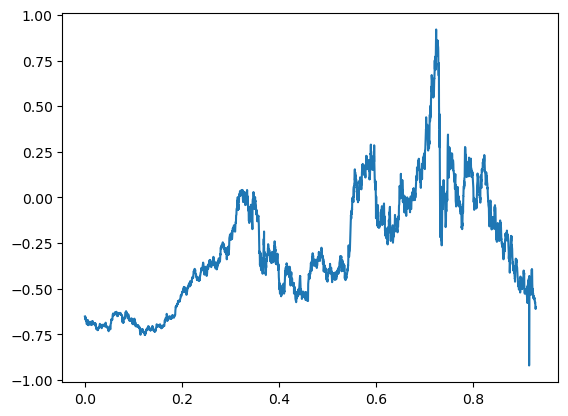

In [61]:
dataset = scaledData[scaledData['Symbol'] == biggest].drop('Symbol', axis=1)
dataset.sort_values(by=['Day'])

# Iremos escalar novamente os dados ja que vamos usar apenas para uma ação
scaler2 = MinMaxScaler((-1 + minMaxMargin, 1 - minMaxMargin))
dataset[scalableFeats] = scaler2.fit_transform(dataset[scalableFeats])

display(dataset.head(6))

from matplotlib import pyplot as plt
plt.plot(dataset['Day'], dataset['Open'])
display()

Agora, iremos treinar nosso modelo.
Primeiramente, iremos transformar o dataset de forma
que ele possa ser usado pelo nosso modelo.
Para isso, iremos usar o conceito de lookback, que
define uma janela de quantos dias para trás o dataset
deve considerar em cada iteração do treino.

Iremos criar um array em que cada posição será um bloco
de dados considerando os n dias anteriores. O array de
resultados para prever terá para cada bloco de dados
desses o dia atual que deve ser previsto.
Usaremos um lookback de 4, considerando 4 dias anteriores.

Separaremos os 70% iniciais dos dados para treino e os 30%
restantes para teste:

In [62]:
def createDataset(dataset, predictFeats, lookBack):
    dataX, dataY = [], []
    for i in range(len(dataset)-lookBack):
        a = dataset.iloc[i: i + lookBack, :]
        dataX.append(a)
        dataY.append(dataset.iloc[i + lookBack, :].loc[predictFeats])

    return np.array(dataX), np.array(dataY)


trainSize = int(len(dataset) * 0.7)
trainSet, testSet = dataset.iloc[:trainSize, :], dataset.iloc[trainSize:, :]
print(len(trainSet), len(testSet))

lookBack = 4
predictFeats = ['Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume']

trainX, trainY = createDataset(trainSet, predictFeats, lookBack)
testX, testY = createDataset(testSet, predictFeats, lookBack)

2277 976


Agora que preparamos os dados para treino,
podemos criar e treinar nosso modelo:

In [63]:
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow import keras
from keras import layers

set_seed(42)

model = keras.Sequential([
    layers.LSTM(
        len(predictFeats),
        input_shape=(lookBack, len(dataset.columns))
    )
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=5, batch_size=1, verbose=1)
display()

Epoch 1/5


2023-06-06 16:48:26.016799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 16:48:26.017878: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 16:48:26.018705: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

2273/2273 [==============================] - 22s 9ms/step - loss: 0.0291
Epoch 2/5
2273/2273 [==============================] - 20s 9ms/step - loss: 0.0022
Epoch 3/5
2273/2273 [==============================] - 20s 9ms/step - loss: 0.0016
Epoch 4/5
2273/2273 [==============================] - 19s 8ms/step - loss: 0.0014
Epoch 5/5
2273/2273 [==============================] - 21s 9ms/step - loss: 0.0013


## Prevendo e analisando resultados

Agora, usamos nosso modelo para prever os dados:

In [64]:
from sklearn.metrics import mean_squared_error

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
display(len(trainX))

# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

trainPredict = pd.DataFrame(trainPredict, columns=predictFeats)
testPredict = pd.DataFrame(testPredict, columns=predictFeats)

display(trainPredict.head(3))
display(testPredict.head(3))

22/72 [========>.....................] - ETA: 0s

2023-06-06 16:50:38.174678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-06 16:50:38.176476: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-06 16:50:38.177433: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

31/31 [==============================] - 0s 3ms/step


2273

Train Score: 0.03 RMSE
Test Score: 0.15 RMSE


,Adj Close,Close,High,Low,Open,Volume
0,-0.865108,-0.820771,-0.663986,-0.659994,-0.651850,-0.893405
1,-0.866080,-0.825422,-0.665731,-0.660083,-0.658759,-0.895363
2,-0.861322,-0.820902,-0.659458,-0.664332,-0.653772,-0.896944


,Adj Close,Close,High,Low,Open,Volume
0,-0.101075,-0.089740,0.012450,-0.004219,-0.043891,-0.870713
1,-0.112120,-0.091259,0.007909,-0.020067,-0.040738,-0.860463
2,-0.121747,-0.100202,-0.000417,-0.021919,-0.049387,-0.870215


Visualização os dados:

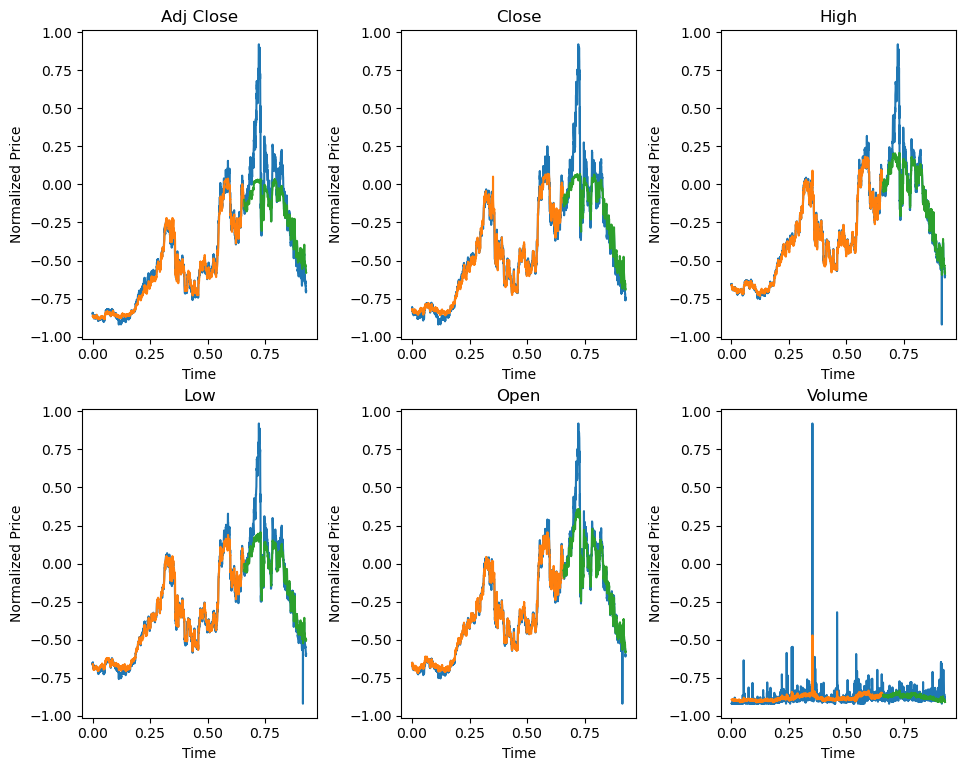

In [65]:
fig, axs = plt.subplots(2, 3, figsize=(10, 8))
fig.tight_layout(pad=3.0)
for ind in range(6):
    i = ind // 3
    j = ind % 3
    feat = predictFeats[ind]
    
    axs[i, j].plot(dataset['Day'], dataset[feat])
    axs[i, j].plot(trainSet['Day'].iloc[lookBack:], trainPredict[feat])
    axs[i, j].plot(testSet['Day'].iloc[lookBack:], testPredict[feat])
    axs[i, j].set(xlabel='Time', ylabel='Normalized Price')
    axs[i, j].set_title(feat)
